In [1]:
%cd ..

f:\DS Lab\OT\ot-kpgg-fc


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Threshold reached at iteration 13
Dimension: 5, Accuracy: {'KeypointFOT': 0.44, 'FOT': 0.155, 'LOT': 0.2175, 'OT': 0.2225}, Runtime: {'KeypointFOT': 14.03775691986084, 'FOT': 29.410093069076538, 'LOT': 0.34552717208862305, 'OT': 0.073486328125}
Threshold reached at iteration 38
Dimension: 10, Accuracy: {'KeypointFOT': 0.41, 'FOT': 0.1575, 'LOT': 0.22, 'OT': 0.2175}, Runtime: {'KeypointFOT': 39.20543837547302, 'FOT': 27.60794758796692, 'LOT': 0.34013819694519043, 'OT': 0.05968928337097168}
Threshold reached at iteration 12
Dimension: 15, Accuracy: {'KeypointFOT': 0.4625, 'FOT': 0.235, 'LOT': 0.2425, 'OT': 0.2075}, Runtime: {'KeypointFOT': 9.825231790542603, 'FOT': 14.458978414535522, 'LOT': 0.359027624130249, 'OT': 0.06020998954772949}
Threshold reached at iteration 11
Dimension: 20, Accuracy: {'KeypointFOT': 0.44, 'FOT': 0.15, 'LOT': 0.2225, 'OT': 0.18}, Runtime: {'KeypointFOT': 8.739977598190308, 'FOT': 12.236559867858887, 'LOT': 0.4196624755859375, 'OT': 0.07133340835571289}
Dimensio

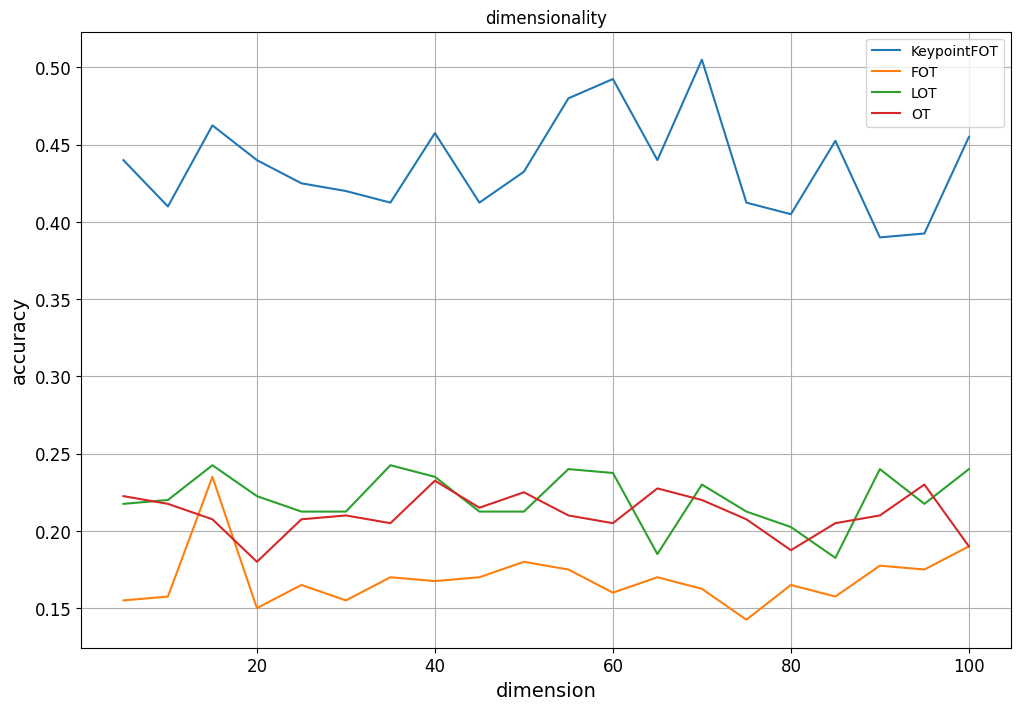

In [3]:
#@title Dimensionality
n_anchors = 4
n_keypoints = 4
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=3*n_anchors, alpha=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, 5-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = Dimensionality(model=models, log_dir="logs")
results = experiment(noise_level=0.5, max_projected_dim=100, freq_projected_dim=5, hyperplane_dim=5,
                     n_components=k, cluster_samples=100, n_keypoints=n_keypoints, 
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                     )

Threshold reached at iteration 15
Noise ratio: 0.0, Accuracy: {'KeypointFOT': 0.8675, 'FOT': 0.495, 'LOT': 0.305, 'OT': 0.295}, Runtime: {'KeypointFOT': 12.566055536270142, 'FOT': 10.331575870513916, 'LOT': 2.832441568374634, 'OT': 0.15648579597473145}
Noise ratio: 0.0, Accuracy: {'KeypointFOT': 0.8675, 'FOT': 0.495, 'LOT': 0.305, 'OT': 0.295}, Runtime: {'KeypointFOT': 12.566055536270142, 'FOT': 10.331575870513916, 'LOT': 2.832441568374634, 'OT': 0.15648579597473145}
Threshold reached at iteration 8
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 0.7575, 'FOT': 0.4925, 'LOT': 0.295, 'OT': 0.295}, Runtime: {'KeypointFOT': 7.110408782958984, 'FOT': 8.285254001617432, 'LOT': 2.282927989959717, 'OT': 0.13626885414123535}
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 0.7575, 'FOT': 0.4925, 'LOT': 0.295, 'OT': 0.295}, Runtime: {'KeypointFOT': 7.110408782958984, 'FOT': 8.285254001617432, 'LOT': 2.282927989959717, 'OT': 0.13626885414123535}
Threshold reached at iteration 49
Noise ratio: 0.2, Accurac

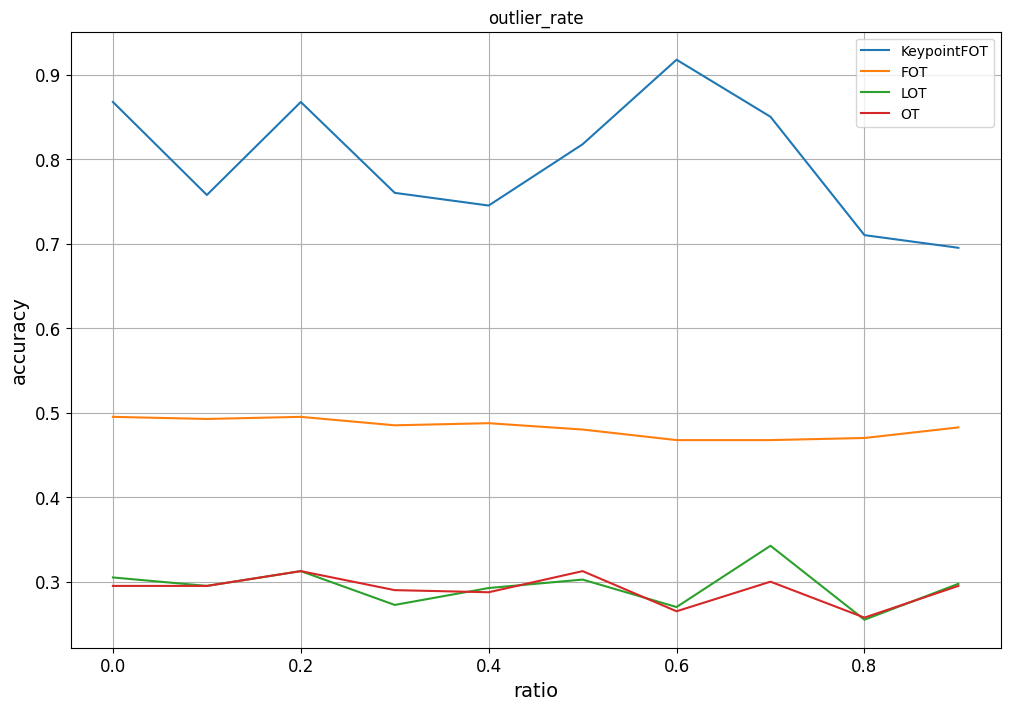

In [6]:

#@title Outlier rate
n_anchors = 4
n_keypoints = 4
d = 30
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=3*n_anchors, alpha=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, 
                     cluster_samples=100, n_keypoints=n_keypoints, n_components=k,
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                    )

Threshold reached at iteration 48
Number of source components: 2, Accuracy: {'KeypointFOT': 0.105, 'FOT': 0.06, 'LOT': 0.0, 'OT': 0.125}, Runtime: {'KeypointFOT': 50.42722296714783, 'FOT': 12.948404312133789, 'LOT': 0.9752132892608643, 'OT': 0.1131751537322998}
Number of source components: 2, Accuracy: {'KeypointFOT': 0.105, 'FOT': 0.06, 'LOT': 0.0, 'OT': 0.125}, Runtime: {'KeypointFOT': 50.42722296714783, 'FOT': 12.948404312133789, 'LOT': 0.9752132892608643, 'OT': 0.1131751537322998}
Threshold reached at iteration 8
Number of source components: 3, Accuracy: {'KeypointFOT': 0.04666666666666667, 'FOT': 0.06666666666666667, 'LOT': 0.0, 'OT': 0.15}, Runtime: {'KeypointFOT': 7.724238634109497, 'FOT': 6.980504035949707, 'LOT': 0.7948219776153564, 'OT': 0.20012569427490234}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.04666666666666667, 'FOT': 0.06666666666666667, 'LOT': 0.0, 'OT': 0.15}, Runtime: {'KeypointFOT': 7.724238634109497, 'FOT': 6.980504035949707, 'LOT': 0.7948219776

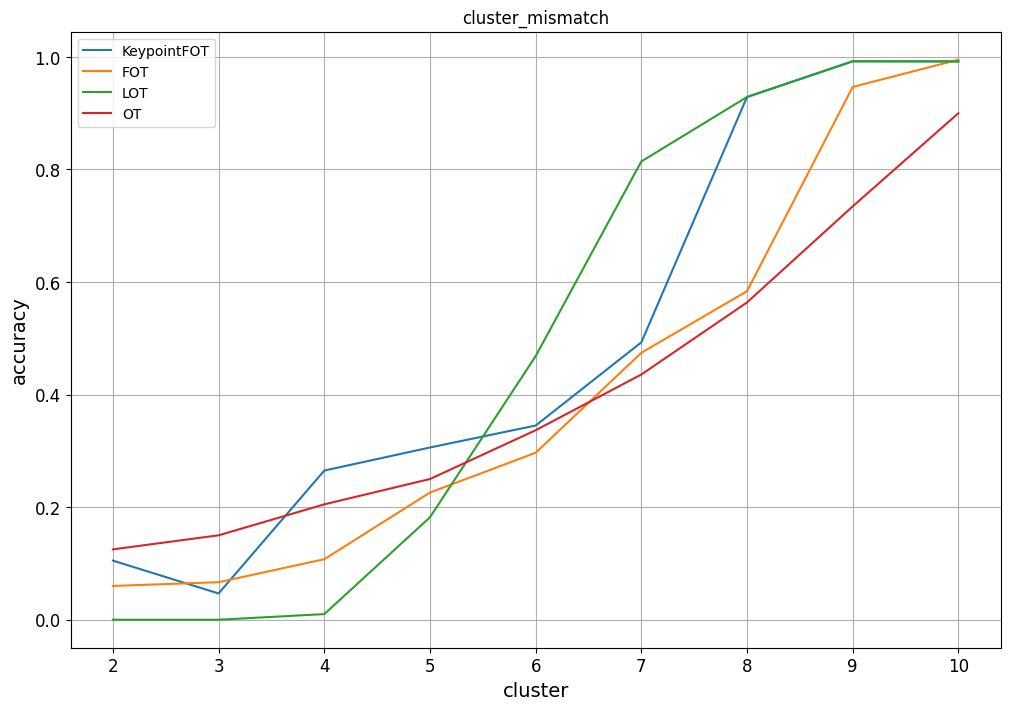

{'KeypointFOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.105,
   0.04666666666666667,
   0.265,
   0.306,
   0.345,
   0.4928571428571429,
   0.92875,
   0.9922222222222222,
   0.992],
  'runtime': [50.42722296714783,
   7.724238634109497,
   8.86047077178955,
   8.39025354385376,
   10.157841920852661,
   43.948628187179565,
   1.8186171054840088,
   2.1064305305480957,
   2.601623058319092]},
 'FOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.06,
   0.06666666666666667,
   0.1075,
   0.226,
   0.2966666666666667,
   0.4742857142857143,
   0.58375,
   0.9466666666666667,
   0.995],
  'runtime': [12.948404312133789,
   6.980504035949707,
   4.407712459564209,
   6.224694013595581,
   7.97756028175354,
   8.28603482246399,
   4.4798219203948975,
   6.606372356414795,
   6.113876581192017]},
 'LOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.0,
   0.0,
   0.01,
   0.182,
   0.4683333333333333,
   0.8142857142857143,
   0.92875,
   0.99222

In [7]:

#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=3*n_anchors, alpha=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = ClusterMismatch(model=models, log_dir="logs")
experiment(min_source_components=2, freq_components=1, target_components=k, 
           hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints,
           src_properties={"means": mean_s, "cov_scale": 0.1},
           trg_properties={"means": mean_t, "cov_scale": 0.1},
           )